In [1]:
# for each cluster of camels basins, find the most sensitive parameters

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import glob, os, sys

# load data

In [2]:
dtmp = np.load('SA_data.npz', allow_pickle=True)
df_param = pd.DataFrame(dtmp['df_param'])
df_info = pd.DataFrame(dtmp['df_info'])
params = dtmp['params']
paramnames = dtmp['paramnames'][:-3]# the last three are binding parameters
# paramnames = df_param[3].values
kge = dtmp['kge']
df_info.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1013500,0.0,-68.56551,47.01169,2303988086.78,277.49349,NaN,NaN,647993,RawTDX,...,2246.946668,2246.628415,2246.132802,0.022767,-0.002554,-0.002695,-0.002915,0.002554,POLYGON ((-68.84000529335947 46.73746031546882...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
1,1022500,0.0,-68.07313,44.79691,620387273.442,103.6042,NaN,NaN,312624,HSTDX,...,615.173865,586.427404,586.60245,0.081568,0.072479,0.022363,0.022668,0.022363,POLYGON ((-68.13005554673525 44.64716666195261...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
2,1030500,0.0,-68.14985,45.80527,3676154745.1,174.433896,NaN,NaN,662248,RawCAMELS,...,3654.475429,3653.788946,3653.84583,-0.000004,-0.005901,-0.006088,-0.006073,0.000004,POLYGON ((-68.35800170861474 45.67902755716805...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
3,1031500,0.0,-69.58119,45.23568,766544703.216,304.74349,NaN,NaN,309614,RawCAMELS,...,775.632787,772.001421,772.168545,-0.003258,0.00856,0.003838,0.004055,0.003258,POLYGON ((-69.67646789509475 45.14558029212971...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
4,1047000,0.0,-70.16213,44.98744,904956194.351,379.779978,NaN,NaN,310157,RawCAMELS,...,914.491471,914.237495,913.814091,-0.004558,0.005931,0.005651,0.005185,0.004558,POLYGON ((-70.10847473135688 45.21669387774366...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...


In [3]:
dtmp = np.load('SA_pyviscous_output.npz', allow_pickle=True)
sens_indx_first = dtmp['sens_indx_first']
sens_indx_total = dtmp['sens_indx_total']

In [4]:
# # remove Basins without sensitivity analysis
# indnosen = sens_indx_first[0,:]<0
# print('Basins without sensitivity analysis:', len(indnosen))

# kge = kge[:, ~indnosen]
# sens_indx_first = sens_indx_first[:,~indnosen]
# sens_indx_total = sens_indx_total[:,~indnosen]
# df_info = df_info.loc[~indnosen]

In [5]:
# Basins with total sensitivity < 0
indneg = []
for i in range(sens_indx_total.shape[1]):
    indi = sens_indx_total[:,i]<0
    num = np.sum(indi)
    if num>0:
        # print(i, '--', num)
        indneg.append( [i, num] )

    # negative values to zero
    sens_indx_total[indi, i] = 0

# indneg = np.array(indneg)
# dtmp = sens_indx_total[:, indneg[:,0]]
# plt.plot(dtmp)
# plt.show()

In [6]:
# # load basin cluster results: method-1
# infile = '../camels_cluster/CAMELS_level1_627_clusters.csv'
# df_cluster = pd.read_csv(infile)
# df_cluster

# if np.any( (df_info[0] - df_cluster['hru_id']).values !=0 ):
#     print('Mistmatch between basins and clusters')
# else:
#     print('basins and clusters match')

In [7]:
infile = '../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt'
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(columns={'Camels_IDs':'hru_id', 'flood_cluster':'clusters'})
df_cluster2 = pd.DataFrame()

for id in df_info[0].values:
    dfi = df_cluster.loc[df_cluster['hru_id']==id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster['clusters'] = df_cluster['clusters'] - 1 # starting from 0

if np.any( (df_info[0] - df_cluster['hru_id']).values !=0 ):
    print('Mistmatch between basins and clusters')
else:
    print('basins and clusters match')

basins and clusters match


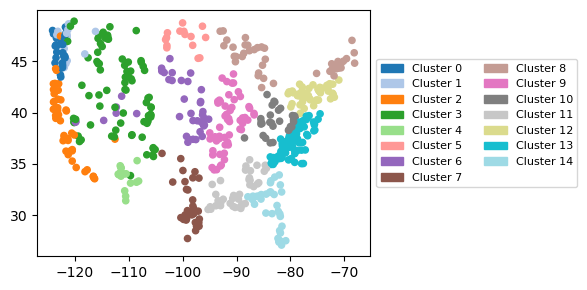

In [8]:
# plot clusters
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches


lat = df_info[3].values
lon = df_info[2].values

fig, ax = plt.subplots(figsize=[6, 3])

# Create a scatter plot
scatter = ax.scatter(lon, lat, c=df_cluster['clusters'], cmap='tab20', s=20)

# Create a legend
legend_labels = {int(cluster): mpatches.Patch(color=color, label=f'Cluster {int(cluster)}')
                 for cluster, color in zip(df_cluster['clusters'], scatter.cmap(scatter.norm(scatter.get_array())))}
handles = [legend_labels[cluster] for cluster in range(15)]
plt.legend(handles=handles, bbox_to_anchor=(1.02, 0.8), loc=2, borderaxespad=0, ncol=2, fontsize=8)

plt.tight_layout()
# plt.show()
plt.savefig('basin_clusters.png', dpi=600, bbox_inches='tight', pad_inches=0)

# For each cluster of basins, select the most sensitive parameters
Criteria: sum of first order senstivity of selected parameters should be larger than 80% of the sum of all parameters

0.8297589141816806 0.8527337078803401 12
0.8660316190691623 0.871879276928878 12
0.8286708487380884 0.8485143202904009 12
0.7802451771904348 0.7868224920930922 12
0.7829495955534389 0.7971836151142339 7
0.740939889068344 0.7642199861925304 12
0.7584330258220322 0.7622741581203778 12
0.7114266280689212 0.7148084055433772 10
0.6740398733310976 0.6831750440710419 15
0.7279116809200117 0.7332225380461735 12
0.7430781288940725 0.7470319877830329 14
0.6684649995826297 0.6752337350851106 12
0.6851188948135865 0.6911306204348074 12
0.7226895787226625 0.7299995769788524 11
0.6370621365289297 0.6466720841487458 12


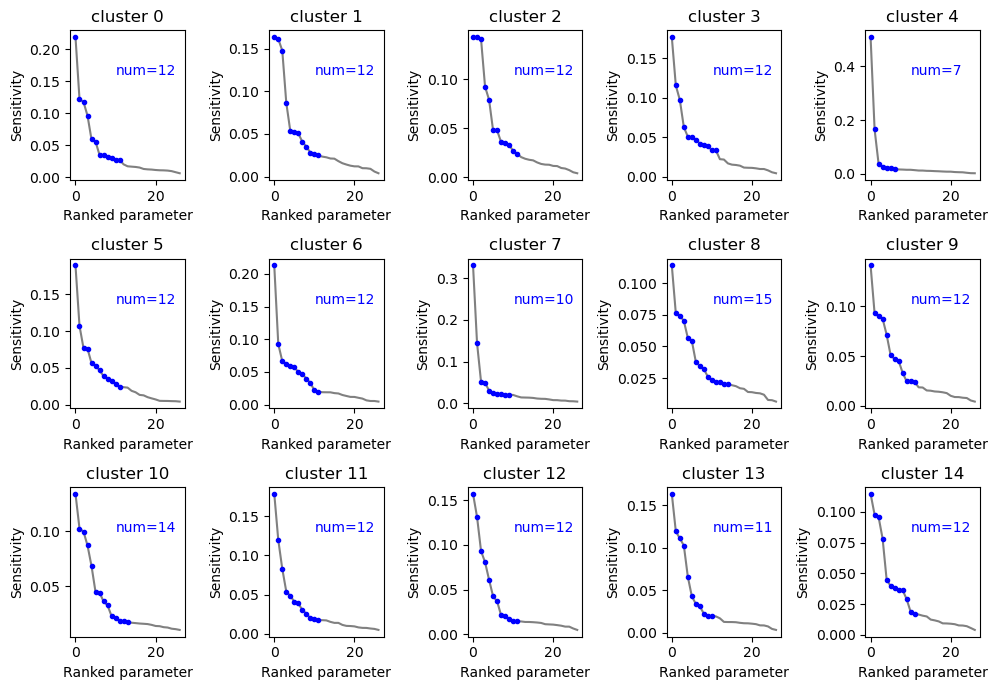

In [9]:
# sort the sensitivity from the highest to the lowest for each cluster

sens_indx_use = sens_indx_first.copy()
# sens_indx_use = sens_indx_total.copy()
sens_indx_use[sens_indx_use<0]=np.nan

use_params = []

fig = plt.figure(figsize=[10, 7])

for i in range(15):
    indexc = df_cluster['clusters'].values==i
    sens_indx_use_c = sens_indx_use[:, indexc]
    sens_indx_use_cm = np.nanmean(sens_indx_use_c, axis=1)
    indsort = np.argsort(-sens_indx_use_cm)
    
    sens_indx_use_cm_sort = sens_indx_use_cm[indsort]
    order = np.arange(len(paramnames))
    order_sort = order[indsort]
    
    ax = fig.add_subplot(3, 5, i+1)
    
    plt.plot(order, sens_indx_use_cm_sort, color='grey')
    # plt.xticks(order, order_sort, rotation=90, fontsize=5)
    plt.title(f'cluster {i}')
    plt.xlabel('Ranked parameter')
    plt.ylabel('Sensitivity')


    # Calculate the total sensitivity
    total_sensitivity = np.sum(sens_indx_use_cm_sort)
    
    # Calculate the cumulative sum of sensitivities
    cumulative_sensitivity = np.cumsum(sens_indx_use_cm_sort)
    
    # Calculate the threshold for 80% of total sensitivity
    threshold_sensitivity = 0.8 * total_sensitivity
    
    # Find the number of parameters required to reach or exceed the 80% threshold
    num_parameters = np.argmax(cumulative_sensitivity >= threshold_sensitivity) + 1  # Adding 1 as arrays are 0-indexed

    # use_params.append(paramnames[indsort][:num_parameters])
    use_params.append(order_sort[:num_parameters])

    # plot those parameters in the figure
    plt.plot(order[:num_parameters], sens_indx_use_cm_sort[:num_parameters], 'ob', markersize=3)
    plt.text(0.4, 0.7, f'num={num_parameters}', color='b', transform=ax.transAxes)
    
    print(threshold_sensitivity, np.sum(sens_indx_use_cm_sort[:num_parameters]), num_parameters)

plt.tight_layout()
# plt.show()
plt.savefig('ranked_sensitivity_allclusters.png', dpi=600, bbox_inches='tight', pad_inches=0)

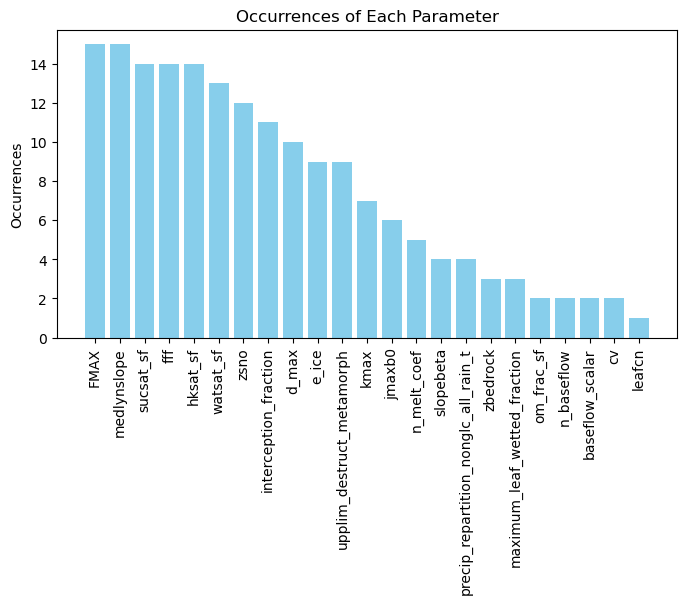

In [10]:
# the occurrence of all parameters selected for calibration
from collections import Counter

# Flatten the list of arrays into a single list
all_params = np.concatenate(use_params)

# Count the occurrences of each integer
occurrences = Counter(all_params)

# Convert the occurrences dictionary to a sorted list by parameter number for plotting
params_sorted = np.array(sorted(occurrences.items()))

# Save the sorted occurrences to an array
# The first column contains the parameter numbers, and the second column contains the occurrences
sorted_params_array = np.array(params_sorted)
indsort = np.argsort(-sorted_params_array[:,1])
sorted_params_array = sorted_params_array[indsort, :]

paramnames_calib = paramnames[sorted_params_array[:,0]]
occurrence_calib = sorted_params_array[:,1]

# Example plotting code
plt.figure(figsize=(8, 4))
# plt.bar(sorted_params_array[:, 0], sorted_params_array[:, 1], color='skyblue')
plt.bar(paramnames_calib,occurrence_calib, color='skyblue')
# plt.xlabel('Parameter Number')
plt.ylabel('Occurrences')
plt.title('Occurrences of Each Parameter')
plt.xticks(rotation=90)
plt.show()
# plt.savefig('parameter_occurrence_allbasins.png', dpi=600, bbox_inches='tight', pad_inches=0)

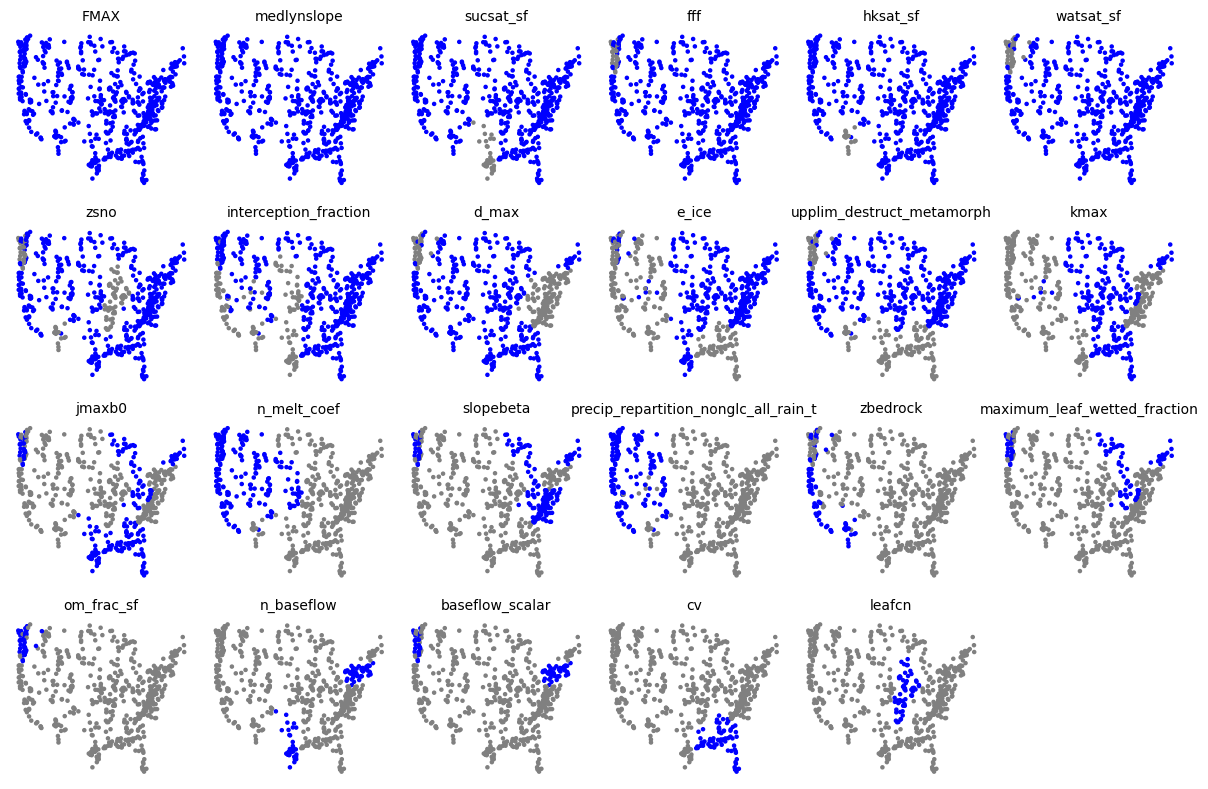

<Figure size 640x480 with 0 Axes>

In [11]:
fig = plt.figure(figsize=[12, 8])

for j in range(len(paramnames_calib)):
    # p = 'n_melt_coef'
    p = paramnames_calib[j]
    indp = np.where(paramnames==p)[0][0]
    
    
    usep = np.zeros(len(df_cluster))
    for i in range(len(use_params)):
        if indp in use_params[i]:
            indi = df_cluster['clusters'].values==i
            usep[indi] = 1

    fig.add_subplot(4, 6, j+1)
    cmap = ListedColormap(['grey', 'blue'])
    plt.scatter(lon, lat, s=5, c=usep, vmin=0, vmax=1, cmap=cmap)
    plt.title(p, fontsize=10)
    plt.axis('off')
    # plt.colorbar()

plt.tight_layout()
plt.show()
plt.savefig('parameter_occurrence_eachcluster.png', dpi=600, bbox_inches='tight', pad_inches=0)

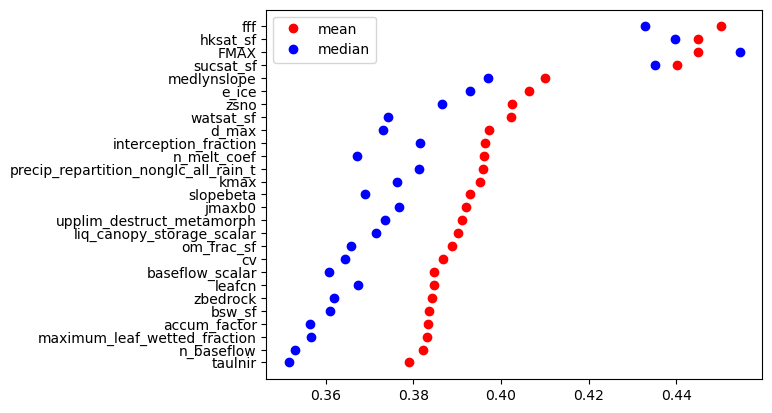

In [12]:
dtmp = sens_indx_total.copy()
dtmp[dtmp<0]=np.nan
sens_indx_first_mean = np.nanmean(dtmp, axis=1)
ind = np.argsort(sens_indx_first_mean)
plt.plot(sens_indx_first_mean[ind], paramnames[ind], 'or', label='mean')

sens_indx_first_mean = np.nanmedian(dtmp, axis=1)
plt.plot(sens_indx_first_mean[ind], paramnames[ind], 'ob', label='median')
plt.legend()
plt.show()

# Save calibration parameters for each basin
Each basin will have a csv file for calibration

In [28]:
infile_SA_param = '../parameter/CTSM_CAMELS_SA_param_240202.csv'
df_SA_param = pd.read_csv(infile_SA_param)

if np.any(df_SA_param['Parameter'].values != df_param[3].values[:-3]):
    print('Warning')
else:
    print('Match')

Match


In [41]:
outpath = '/glade/work/guoqiang/CTSM_CAMELS/data_paramcailb/'
os.makedirs(outpath, exist_ok=True)

for i in range(len(df_cluster)):
    idi = df_cluster.iloc[i]['hru_id']
    ci = df_cluster.iloc[i]['clusters']

    outfilei = f'{outpath}/ParamCalib_{idi}.csv'

    use_parami = use_params[ci]
    dfi = df_SA_param.loc[use_parami]

    dfi.to_csv(outfilei, index=False)

# Analyze one cluster

In [13]:
# test-1: Texas
tc = 7
tarparam = 'zsno'

# # test-2: California
# tc = 2
# tarparam = 'precip_repartition_nonglc_all_rain_t'

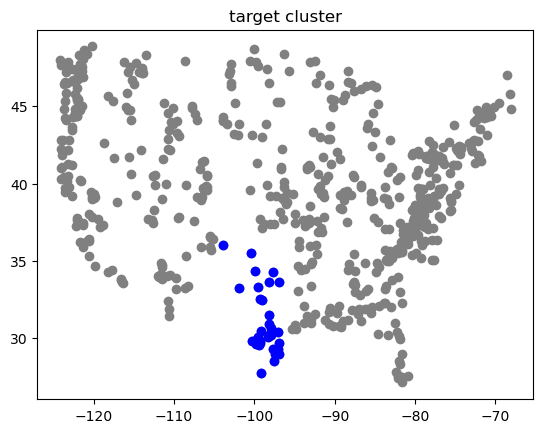

selected params for this cluster: ['fff' 'FMAX' 'zsno' 'medlynslope' 'hksat_sf' 'watsat_sf' 'd_max' 'e_ice'
 'jmaxb0' 'n_baseflow']


In [14]:
indcluster = df_cluster['clusters'].values==tc
plt.scatter(lon, lat, color='grey')
plt.scatter(lon[indcluster], lat[indcluster], color='blue')
plt.title('target cluster')
plt.show()

print('selected params for this cluster:', paramnames[use_params[tc]])

zsno 0.0512753890873677


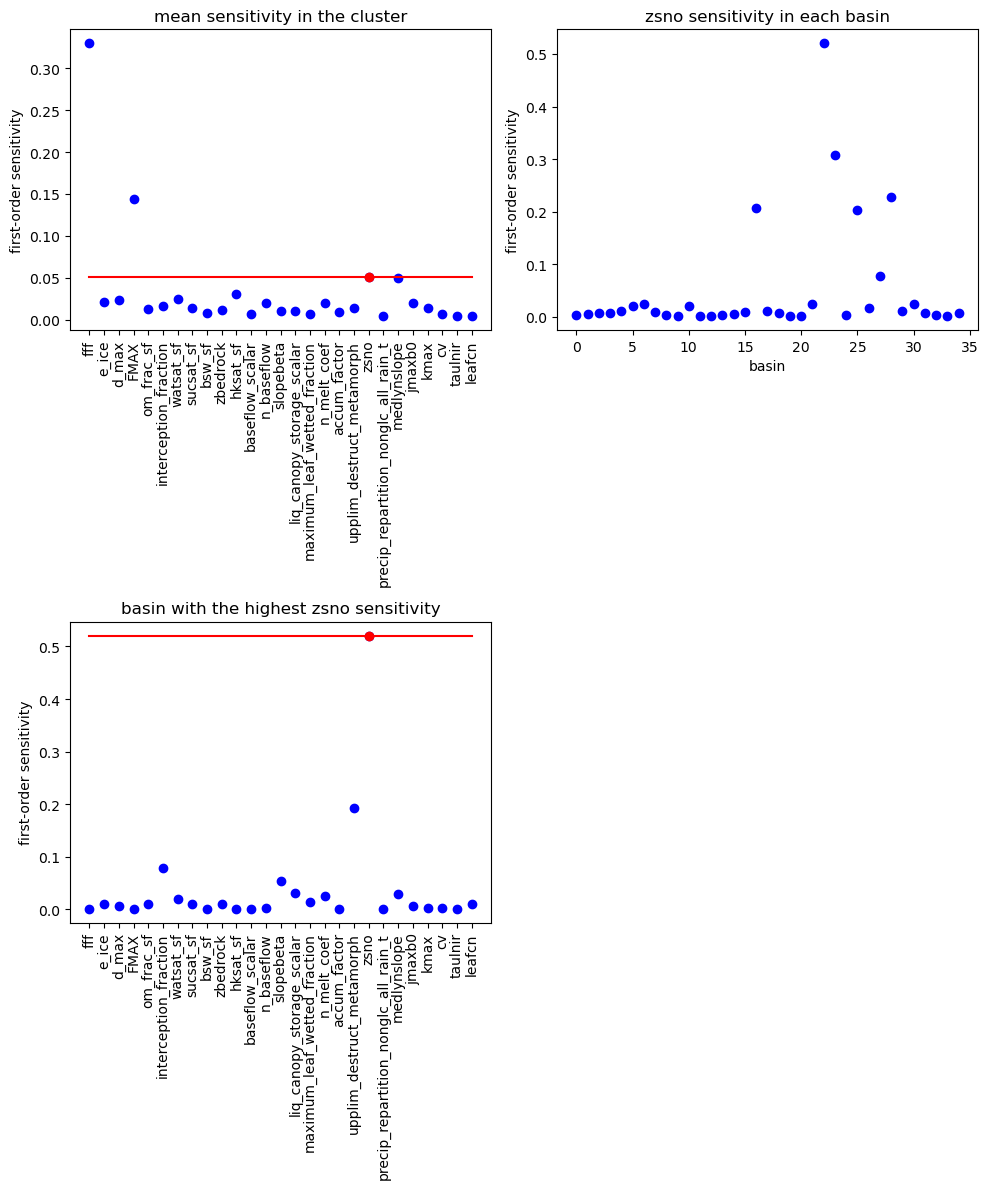

In [15]:
# plot mean sensitivity within this cluster
dtmp = sens_indx_first[:, indcluster].copy()
dtmp[dtmp<0]=np.nan
ms = np.nanmean(dtmp,axis=1)

ind = np.where(paramnames==tarparam)[0][0]
print(tarparam, ms[ind])

fig = plt.figure(figsize=[10, 12])

fig.add_subplot(2,2,1)
plt.plot(paramnames, ms, 'ob')
plt.plot(tarparam, ms[ind], 'or')
plt.plot(paramnames, ms[ind] * np.ones(len(paramnames)), 'r')
plt.xticks(rotation=90)
plt.ylabel('first-order sensitivity')
plt.title('mean sensitivity in the cluster')

fig.add_subplot(2,2,2)
plt.plot(dtmp[ind, :], 'ob')
plt.title(f'{tarparam} sensitivity in each basin')
plt.xlabel('basin')
plt.ylabel('first-order sensitivity')


fig.add_subplot(2, 2, 3)
# ind2 = np.argmax(dtmp[ind, :])
ind2 = np.argsort(-dtmp[ind, :])[0]
plt.plot(paramnames, dtmp[:,ind2], 'ob')
plt.plot(tarparam, dtmp[:,ind2][ind], 'or')
plt.plot(paramnames, dtmp[:,ind2][ind] * np.ones(len(paramnames)), 'r')
plt.xticks(rotation=90)
plt.ylabel('first-order sensitivity')
plt.title(f'basin with the highest {tarparam} sensitivity')

plt.tight_layout()
plt.show()

In [16]:
print(f'basin with the highest {tarparam} sensitivity:', ind2)
print('Basin info')
df_tmp = df_info[indcluster].iloc[[ind2]]
display(df_tmp)

basin with the highest zsno sensitivity: 22
Basin info


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
430,8171300,0.0,-98.31502,30.04894,1073941980.54,399.810585,NaN,NaN,320360,MHTDX,...,1073.227839,1065.991166,1068.154787,0.006063,0.005394,-0.001385,0.000642,0.000642,POLYGON ((-98.51361110111226 30.00483332333423...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...


In [17]:
# load simulation results for this basin

years = np.arange(2004, 2010)
files = []
path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs'
for y in years:
    filesy = glob.glob(f'{path}/iter0_trial73/lnd/hist/level1_iter0_trial73.clm2.h0.{y}-*')
    filesy.sort()
    files = files + filesy

ds_simu = xr.open_mfdataset(files)

checkbasin = df_tmp.index.values[0]
ds_simu = ds_simu.isel(lndgrid=checkbasin)


In [18]:
# load observed streamflow
path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_evaluation'
file = f'{path}/obs_streamflow.nc'
ds_q_obs = xr.load_dataset(file)
ds_q_obs = ds_q_obs.isel(lndgrid=checkbasin).sel(time=slice(str(years[0]), str(years[-1])))

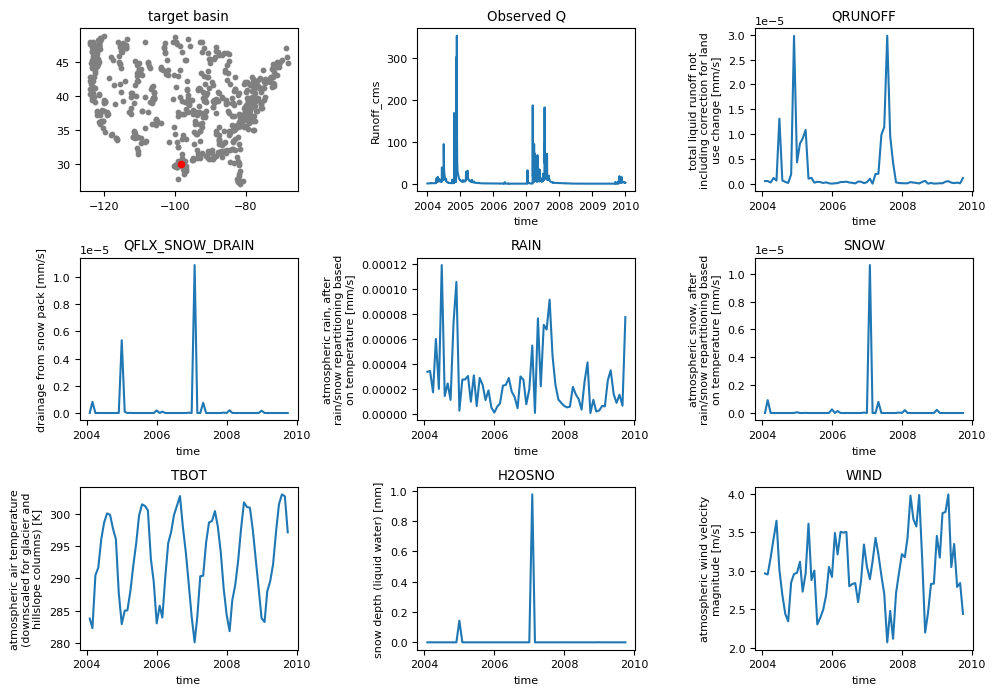

In [19]:
plotvars = ['QRUNOFF', 'QFLX_SNOW_DRAIN', 'RAIN', 'SNOW', 'TBOT', 'H2OSNO', 'WIND']

font = {'size'   : 8}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, 7])


fig.add_subplot(3, 3, 1)
plt.scatter(lon, lat, s=10, color='grey')
plt.scatter(df_tmp[2].values, df_tmp[3].values, s=20, color='red')
plt.title('target basin')

fig.add_subplot(3, 3, 2)
ds_q_obs['Runoff_cms'].plot()
plt.title('Observed Q')

for i in range(len(plotvars)):
    vari = plotvars[i]

    fig.add_subplot(3, 3, i+3)
    ds_simu[vari].plot()
    plt.title(vari)

plt.tight_layout()
plt.show()
